In [77]:
import torch
from torch import nn
from torch.nn import functional
from torch import optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

In [78]:
class Discriminator(nn.Module):
    def __init__(self,channels_img,feature):
        # Input Size Batch_SIZE X Channels X 64 X 64
        super(Discriminator,self).__init__()
        self.disc=nn.Sequential(
            nn.Conv2d(channels_img,feature,kernel_size=4,stride=2,padding=1), # # 32x32 input/stride
            nn.LeakyReLU(0.2),
            self._CNNblock_(feature , feature*2 , 4 , 2 , 1), # 16x16
            self._CNNblock_(feature*2 , feature*4 , 4 , 2 , 1),# 8x8
            self._CNNblock_(feature*4 , feature*8 , 4 , 2 , 1), #4x4
            nn.Conv2d(feature*8 , 1 , kernel_size=4, stride=2 , padding=0), # 1x1
            nn.Sigmoid(),
        )

    def _CNNblock_(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self,x):
        return self.disc(x)
    

In [79]:
class Generator(nn.Module):
    def __init__(self,z_dims,channel_img,feature):
        super(Generator,self).__init__()
        self.gen=nn.Sequential(
            self._TransposeBlock_(z_dims,feature*16,kernel_size=4,stride=2,padding=0),
            self._TransposeBlock_(feature*16,feature*8,kernel_size=4,stride=2,padding=1),
            self._TransposeBlock_(feature*8,feature*4,kernel_size=4,stride=2,padding=1),
            self._TransposeBlock_(feature*4,feature*2,kernel_size=4,stride=2,padding=1),
            nn.ConvTranspose2d(feature*2,channel_img,kernel_size=4,stride=2,padding=1),
            nn.Tanh() # Tanh Converts Output in between [-1,1]
        )
        
        
    def _TransposeBlock_(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self,x):
        return self.gen(x)

In [80]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# HyperParameters
BATCH_SIZE=128
lr=2e-4
z_dims=100
IMAGE_SIZE=64
CHANNELS_IMG=1
FEATURE_DIS=64
FEATURE_GEN=64
epochs=5

In [82]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)
dataset=datasets.MNIST(root="",train=True,transform=transforms,download=True)
loader=DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True)

In [83]:
DIS=Discriminator(CHANNELS_IMG,FEATURE_DIS).to(device)
GEN=Generator(z_dims,CHANNELS_IMG,FEATURE_GEN).to(device)
initialize_weights(GEN)

initialize_weights(DIS)

opt_gen=optim.Adam(GEN.parameters(),lr=lr,betas=(0.5,0.999))
opt_dis=optim.Adam(DIS.parameters(),lr=lr,betas=(0.5,0.999))
Critetion=nn.BCELoss()

Epoch:0,   G_loss:0.8882811069488525,    D_loss:0.5768470764160156


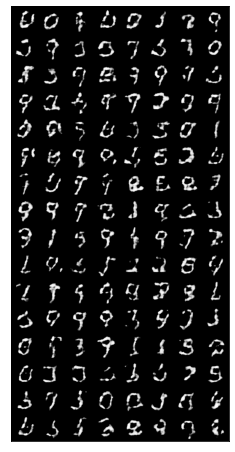

Epoch:1,   G_loss:0.6757776737213135,    D_loss:0.6241949200630188


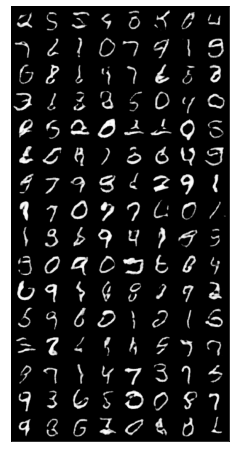

Epoch:2,   G_loss:1.6858692169189453,    D_loss:0.43931034207344055


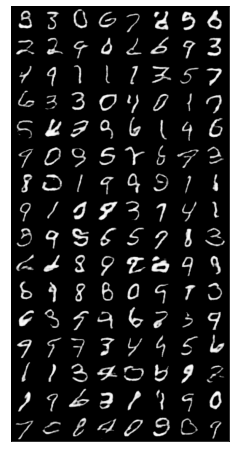

Epoch:3,   G_loss:1.5485317707061768,    D_loss:0.38684922456741333


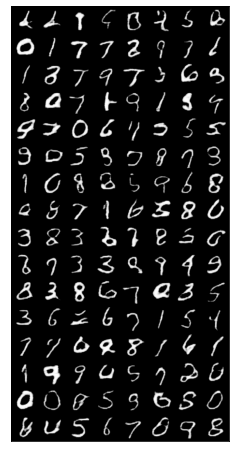

Epoch:4,   G_loss:3.018517017364502,    D_loss:0.09343224763870239


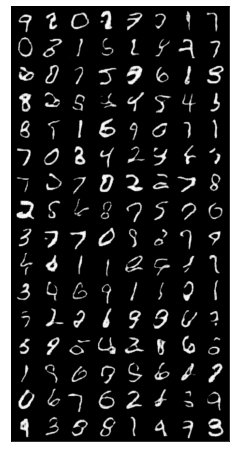

In [84]:
from matplotlib import pyplot as plt
import numpy as np
import numpy
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

for epoch in range(epochs):
    for idx, (real,_) in enumerate(loader):
        real=real.to(device)
        noise=torch.randn((BATCH_SIZE,z_dims,1,1)).to(device)
        #Discriminator
        realout=DIS(real).view(-1)
        fakenoise=GEN(noise)
        fakeout=DIS(fakenoise).view(-1)
        lossD_Real=Critetion(realout,torch.ones_like(realout))
        lossD_Fake=Critetion(fakeout,torch.zeros_like(fakeout))
        lossD=(lossD_Real+lossD_Fake)/2
        
        DIS.zero_grad()
        lossD.backward(retain_graph=True)
        opt_dis.step()
        
        #Generator
        output=DIS(fakenoise).view(-1)
        lossG=Critetion(output,torch.ones_like(output))
        GEN.zero_grad()
        lossG.backward()
        opt_gen.step()
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, lossG, lossD))
    noise=torch.randn((BATCH_SIZE,z_dims,1,1)).to(device)

    samples=GEN(noise)
    samples = samples.view(samples.size(0), 1, 64, 64).to(device)
    imshow(samples)
        
        
        

In [85]:
pred=GEN(noise)

In [93]:
# Generated Mnist Images

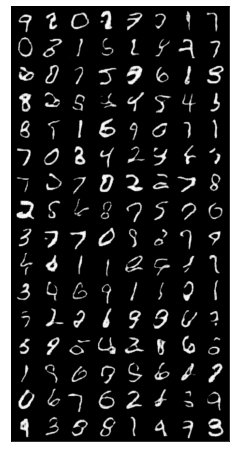

In [99]:
noise=torch.randn((BATCH_SIZE,z_dims,1,1)).to(device)
with torch.no_grad():
  pred=GEN(noise)
  samples = samples.view(noise.size(0), 1, 64, 64).to(device)
  imshow(samples)